In [284]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
plt.rcParams['figure.figsize'] = (10, 8)

In [6]:
import sys
sys.path.insert(0, '../rapid2018/')

In [7]:
from load_data import load_data, load_directory
from clustering import clustering, predict_cluster

In [8]:
file = '../vertex_finding/data/train/RapidVPData_6915602_43417.json'

In [9]:
df = load_data(file)

In [10]:
df = predict_cluster(df, 1.625)

In [276]:
def add_vertex_info(df):
    df['cluster_x'] = df['cluster_y'] = df['cluster_z'] = np.nan
    
    for cluster in df.cluster_idx.unique():
        if cluster < 0:
            continue

        df.loc[df.cluster_idx == cluster, 'cluster_x'] = df.query(f'cluster_idx == {cluster}').x.mean()
        df.loc[df.cluster_idx == cluster, 'cluster_y'] = df.query(f'cluster_idx == {cluster}').y.mean()
        df.loc[df.cluster_idx == cluster, 'cluster_z'] = df.query(f'cluster_idx == {cluster}').z.mean()
        
    df['x_shifted'] = df.x - df.cluster_x
    df['y_shifted'] = df.y - df.cluster_y
    df['z_shifted'] = df.z - df.cluster_z
    
    return df

In [14]:
df = add_vertex_info(df)

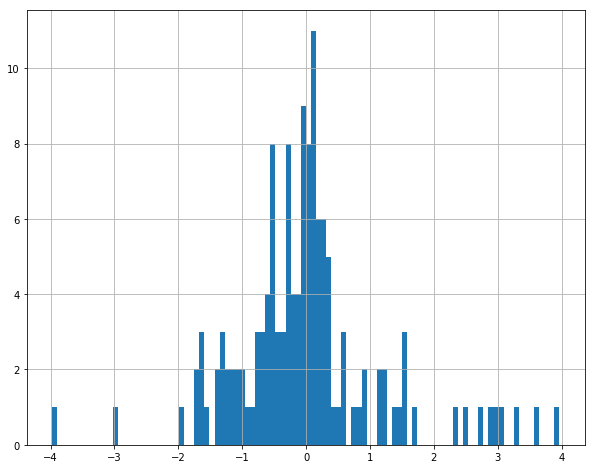

In [15]:
df.z_shifted.hist(bins=100)
plt.show()

In [262]:
dfs = load_directory('../vertex_finding/data/train/', max_files=-1)

100%|██████████| 4996/4996 [43:19<00:00,  2.44it/s]  


In [279]:
def filter_clusters(df, inplace=False):
    df = df.query('cluster_idx >= 0 and mcpvprods > 10', inplace=inplace)
    return df

In [280]:
for df in tqdm(dfs):
    predict_cluster(df)
    add_vertex_info(df)
    filter_clusters(df, inplace=True)



  0%|          | 0/4996 [00:00<?, ?it/s]

  0%|          | 2/4996 [00:00<05:14, 15.86it/s]

  0%|          | 4/4996 [00:00<04:59, 16.65it/s]

  0%|          | 7/4996 [00:00<04:24, 18.83it/s]

  0%|          | 10/4996 [00:00<04:09, 19.97it/s]

  0%|          | 13/4996 [00:00<03:52, 21.39it/s]

  0%|          | 15/4996 [00:00<04:43, 17.58it/s]

  0%|          | 17/4996 [00:00<04:49, 17.21it/s]

  0%|          | 20/4996 [00:00<04:22, 18.97it/s]

  0%|          | 22/4996 [00:01<04:24, 18.83it/s]

  0%|          | 24/4996 [00:01<04:34, 18.11it/s]

  1%|          | 26/4996 [00:01<04:33, 18.17it/s]

  1%|          | 28/4996 [00:01<05:30, 15.05it/s]

  1%|          | 30/4996 [00:01<05:39, 14.62it/s]

  1%|          | 32/4996 [00:01<06:16, 13.17it/s]

  1%|          | 34/4996 [00:02<06:19, 13.06it/s]

  1%|          | 37/4996 [00:02<05:30, 14.99it/s]

  1%|          | 39/4996 [00:02<05:10, 15.96it/s]

  1%|          | 42/4996 [00:02<04:32, 18.16it/s]

  1%|          | 45/4996 [00:02<04:23, 18

  6%|▋         | 319/4996 [00:19<03:42, 20.99it/s]

  6%|▋         | 322/4996 [00:19<03:47, 20.53it/s]

  7%|▋         | 325/4996 [00:19<03:45, 20.72it/s]

  7%|▋         | 328/4996 [00:19<03:42, 20.97it/s]

  7%|▋         | 331/4996 [00:19<03:48, 20.42it/s]

  7%|▋         | 334/4996 [00:20<03:54, 19.88it/s]

  7%|▋         | 336/4996 [00:20<04:33, 17.02it/s]

  7%|▋         | 339/4996 [00:20<04:13, 18.35it/s]

  7%|▋         | 342/4996 [00:20<03:50, 20.18it/s]

  7%|▋         | 345/4996 [00:20<03:43, 20.83it/s]

  7%|▋         | 348/4996 [00:20<03:48, 20.37it/s]

  7%|▋         | 351/4996 [00:20<03:42, 20.89it/s]

  7%|▋         | 354/4996 [00:20<03:30, 22.05it/s]

  7%|▋         | 357/4996 [00:21<03:34, 21.58it/s]

  7%|▋         | 360/4996 [00:21<03:34, 21.59it/s]

  7%|▋         | 363/4996 [00:21<03:34, 21.60it/s]

  7%|▋         | 366/4996 [00:21<03:48, 20.25it/s]

  7%|▋         | 369/4996 [00:21<03:28, 22.19it/s]

  7%|▋         | 372/4996 [00:21<03:14, 23.72it/s]

  8%|▊      

 13%|█▎        | 659/4996 [00:39<03:58, 18.18it/s]

 13%|█▎        | 662/4996 [00:39<04:04, 17.70it/s]

 13%|█▎        | 664/4996 [00:40<04:19, 16.68it/s]

 13%|█▎        | 666/4996 [00:40<04:45, 15.14it/s]

 13%|█▎        | 668/4996 [00:40<04:46, 15.13it/s]

 13%|█▎        | 670/4996 [00:40<04:27, 16.17it/s]

 13%|█▎        | 672/4996 [00:40<04:31, 15.92it/s]

 13%|█▎        | 674/4996 [00:40<04:24, 16.36it/s]

 14%|█▎        | 676/4996 [00:40<04:50, 14.88it/s]

 14%|█▎        | 678/4996 [00:41<04:52, 14.76it/s]

 14%|█▎        | 680/4996 [00:41<05:08, 14.00it/s]

 14%|█▎        | 682/4996 [00:41<04:52, 14.77it/s]

 14%|█▎        | 684/4996 [00:41<04:33, 15.79it/s]

 14%|█▎        | 686/4996 [00:41<04:36, 15.59it/s]

 14%|█▍        | 688/4996 [00:41<04:28, 16.07it/s]

 14%|█▍        | 690/4996 [00:41<04:18, 16.66it/s]

 14%|█▍        | 692/4996 [00:41<04:14, 16.93it/s]

 14%|█▍        | 694/4996 [00:42<04:28, 15.99it/s]

 14%|█▍        | 696/4996 [00:42<04:22, 16.39it/s]

 14%|█▍     

 20%|█▉        | 976/4996 [00:59<03:31, 19.02it/s]

 20%|█▉        | 978/4996 [00:59<03:47, 17.65it/s]

 20%|█▉        | 980/4996 [01:00<03:54, 17.12it/s]

 20%|█▉        | 982/4996 [01:00<04:16, 15.65it/s]

 20%|█▉        | 985/4996 [01:00<04:01, 16.61it/s]

 20%|█▉        | 987/4996 [01:00<04:28, 14.96it/s]

 20%|█▉        | 989/4996 [01:00<04:30, 14.83it/s]

 20%|█▉        | 991/4996 [01:00<04:39, 14.31it/s]

 20%|█▉        | 993/4996 [01:00<04:41, 14.20it/s]

 20%|█▉        | 995/4996 [01:01<05:03, 13.20it/s]

 20%|█▉        | 997/4996 [01:01<05:11, 12.83it/s]

 20%|██        | 1000/4996 [01:01<04:33, 14.60it/s]

 20%|██        | 1002/4996 [01:01<04:20, 15.35it/s]

 20%|██        | 1005/4996 [01:01<03:52, 17.18it/s]

 20%|██        | 1007/4996 [01:01<03:50, 17.32it/s]

 20%|██        | 1009/4996 [01:01<03:57, 16.76it/s]

 20%|██        | 1011/4996 [01:01<03:47, 17.51it/s]

 20%|██        | 1014/4996 [01:02<03:28, 19.14it/s]

 20%|██        | 1016/4996 [01:02<03:41, 17.97it/s]

 20%

 26%|██▋       | 1323/4996 [01:19<03:07, 19.55it/s]

 27%|██▋       | 1326/4996 [01:19<03:07, 19.61it/s]

 27%|██▋       | 1329/4996 [01:19<03:23, 18.00it/s]

 27%|██▋       | 1332/4996 [01:19<03:14, 18.82it/s]

 27%|██▋       | 1334/4996 [01:20<03:22, 18.13it/s]

 27%|██▋       | 1337/4996 [01:20<03:14, 18.84it/s]

 27%|██▋       | 1339/4996 [01:20<03:29, 17.46it/s]

 27%|██▋       | 1343/4996 [01:20<03:05, 19.68it/s]

 27%|██▋       | 1346/4996 [01:20<02:56, 20.62it/s]

 27%|██▋       | 1349/4996 [01:20<02:44, 22.15it/s]

 27%|██▋       | 1352/4996 [01:20<02:39, 22.87it/s]

 27%|██▋       | 1355/4996 [01:20<02:44, 22.17it/s]

 27%|██▋       | 1358/4996 [01:21<02:35, 23.36it/s]

 27%|██▋       | 1361/4996 [01:21<02:41, 22.56it/s]

 27%|██▋       | 1364/4996 [01:21<02:36, 23.23it/s]

 27%|██▋       | 1367/4996 [01:21<02:34, 23.51it/s]

 27%|██▋       | 1370/4996 [01:21<02:39, 22.68it/s]

 27%|██▋       | 1373/4996 [01:21<02:45, 21.83it/s]

 28%|██▊       | 1376/4996 [01:21<02:38, 22.88

 34%|███▍      | 1723/4996 [01:39<02:34, 21.16it/s]

 35%|███▍      | 1726/4996 [01:39<02:55, 18.67it/s]

 35%|███▍      | 1730/4996 [01:39<02:36, 20.88it/s]

 35%|███▍      | 1733/4996 [01:39<02:36, 20.83it/s]

 35%|███▍      | 1736/4996 [01:39<02:32, 21.43it/s]

 35%|███▍      | 1739/4996 [01:39<02:39, 20.37it/s]

 35%|███▍      | 1742/4996 [01:40<02:45, 19.68it/s]

 35%|███▍      | 1745/4996 [01:40<02:51, 18.92it/s]

 35%|███▍      | 1747/4996 [01:40<02:52, 18.83it/s]

 35%|███▌      | 1750/4996 [01:40<02:37, 20.61it/s]

 35%|███▌      | 1753/4996 [01:40<02:43, 19.81it/s]

 35%|███▌      | 1756/4996 [01:40<02:36, 20.65it/s]

 35%|███▌      | 1759/4996 [01:40<02:41, 20.04it/s]

 35%|███▌      | 1762/4996 [01:41<02:32, 21.14it/s]

 35%|███▌      | 1765/4996 [01:41<02:29, 21.60it/s]

 35%|███▌      | 1768/4996 [01:41<02:33, 21.09it/s]

 35%|███▌      | 1771/4996 [01:41<02:53, 18.64it/s]

 36%|███▌      | 1775/4996 [01:41<02:30, 21.42it/s]

 36%|███▌      | 1778/4996 [01:41<02:33, 20.99

 42%|████▏     | 2090/4996 [01:58<03:39, 13.22it/s]

 42%|████▏     | 2092/4996 [01:58<03:59, 12.12it/s]

 42%|████▏     | 2094/4996 [01:58<03:52, 12.49it/s]

 42%|████▏     | 2096/4996 [01:59<03:34, 13.49it/s]

 42%|████▏     | 2098/4996 [01:59<03:23, 14.25it/s]

 42%|████▏     | 2100/4996 [01:59<03:50, 12.54it/s]

 42%|████▏     | 2102/4996 [01:59<03:33, 13.56it/s]

 42%|████▏     | 2104/4996 [01:59<03:18, 14.60it/s]

 42%|████▏     | 2107/4996 [01:59<02:54, 16.54it/s]

 42%|████▏     | 2110/4996 [01:59<02:43, 17.68it/s]

 42%|████▏     | 2113/4996 [02:00<02:34, 18.70it/s]

 42%|████▏     | 2115/4996 [02:00<02:52, 16.73it/s]

 42%|████▏     | 2117/4996 [02:00<02:56, 16.27it/s]

 42%|████▏     | 2119/4996 [02:00<02:52, 16.69it/s]

 42%|████▏     | 2121/4996 [02:00<02:54, 16.50it/s]

 43%|████▎     | 2124/4996 [02:00<02:45, 17.34it/s]

 43%|████▎     | 2127/4996 [02:00<02:30, 19.11it/s]

 43%|████▎     | 2129/4996 [02:00<02:31, 18.90it/s]

 43%|████▎     | 2131/4996 [02:01<02:46, 17.16

 48%|████▊     | 2416/4996 [02:17<03:08, 13.70it/s]

 48%|████▊     | 2418/4996 [02:18<03:16, 13.10it/s]

 48%|████▊     | 2420/4996 [02:18<02:59, 14.34it/s]

 48%|████▊     | 2422/4996 [02:18<03:11, 13.43it/s]

 49%|████▊     | 2424/4996 [02:18<03:11, 13.46it/s]

 49%|████▊     | 2426/4996 [02:18<02:58, 14.36it/s]

 49%|████▊     | 2428/4996 [02:18<03:08, 13.62it/s]

 49%|████▊     | 2430/4996 [02:18<03:08, 13.63it/s]

 49%|████▊     | 2432/4996 [02:19<03:26, 12.41it/s]

 49%|████▊     | 2435/4996 [02:19<03:05, 13.83it/s]

 49%|████▉     | 2437/4996 [02:19<03:20, 12.74it/s]

 49%|████▉     | 2439/4996 [02:19<03:30, 12.16it/s]

 49%|████▉     | 2441/4996 [02:19<03:34, 11.91it/s]

 49%|████▉     | 2443/4996 [02:20<03:38, 11.66it/s]

 49%|████▉     | 2445/4996 [02:20<03:18, 12.83it/s]

 49%|████▉     | 2447/4996 [02:20<03:03, 13.91it/s]

 49%|████▉     | 2449/4996 [02:20<03:15, 13.03it/s]

 49%|████▉     | 2451/4996 [02:20<03:02, 13.93it/s]

 49%|████▉     | 2453/4996 [02:20<03:03, 13.84

 55%|█████▌    | 2756/4996 [02:37<01:55, 19.46it/s]

 55%|█████▌    | 2758/4996 [02:37<01:56, 19.23it/s]

 55%|█████▌    | 2760/4996 [02:37<01:56, 19.11it/s]

 55%|█████▌    | 2762/4996 [02:37<01:56, 19.12it/s]

 55%|█████▌    | 2765/4996 [02:38<01:50, 20.13it/s]

 55%|█████▌    | 2768/4996 [02:38<01:49, 20.28it/s]

 55%|█████▌    | 2771/4996 [02:38<01:49, 20.38it/s]

 56%|█████▌    | 2774/4996 [02:38<01:46, 20.80it/s]

 56%|█████▌    | 2777/4996 [02:38<01:47, 20.57it/s]

 56%|█████▌    | 2780/4996 [02:38<01:42, 21.58it/s]

 56%|█████▌    | 2783/4996 [02:38<01:51, 19.82it/s]

 56%|█████▌    | 2786/4996 [02:39<01:47, 20.57it/s]

 56%|█████▌    | 2789/4996 [02:39<01:50, 19.91it/s]

 56%|█████▌    | 2792/4996 [02:39<01:58, 18.63it/s]

 56%|█████▌    | 2794/4996 [02:39<01:56, 18.91it/s]

 56%|█████▌    | 2796/4996 [02:39<01:55, 19.13it/s]

 56%|█████▌    | 2799/4996 [02:39<01:46, 20.71it/s]

 56%|█████▌    | 2802/4996 [02:39<01:49, 19.98it/s]

 56%|█████▌    | 2805/4996 [02:40<01:45, 20.78

 62%|██████▏   | 3096/4996 [02:56<01:44, 18.23it/s]

 62%|██████▏   | 3098/4996 [02:56<01:45, 17.91it/s]

 62%|██████▏   | 3100/4996 [02:56<01:59, 15.82it/s]

 62%|██████▏   | 3103/4996 [02:57<01:58, 15.93it/s]

 62%|██████▏   | 3105/4996 [02:57<02:04, 15.15it/s]

 62%|██████▏   | 3107/4996 [02:57<02:07, 14.82it/s]

 62%|██████▏   | 3110/4996 [02:57<01:52, 16.73it/s]

 62%|██████▏   | 3112/4996 [02:57<01:49, 17.22it/s]

 62%|██████▏   | 3115/4996 [02:57<01:40, 18.68it/s]

 62%|██████▏   | 3117/4996 [02:57<01:46, 17.61it/s]

 62%|██████▏   | 3119/4996 [02:57<01:47, 17.49it/s]

 62%|██████▏   | 3122/4996 [02:58<01:40, 18.71it/s]

 63%|██████▎   | 3124/4996 [02:58<01:40, 18.69it/s]

 63%|██████▎   | 3126/4996 [02:58<01:50, 16.89it/s]

 63%|██████▎   | 3129/4996 [02:58<01:43, 18.02it/s]

 63%|██████▎   | 3132/4996 [02:58<01:50, 16.83it/s]

 63%|██████▎   | 3134/4996 [02:58<01:52, 16.59it/s]

 63%|██████▎   | 3136/4996 [02:58<01:57, 15.83it/s]

 63%|██████▎   | 3138/4996 [02:59<01:55, 16.04

 69%|██████▉   | 3438/4996 [03:17<01:19, 19.51it/s]

 69%|██████▉   | 3440/4996 [03:17<01:24, 18.34it/s]

 69%|██████▉   | 3443/4996 [03:17<01:18, 19.73it/s]

 69%|██████▉   | 3446/4996 [03:17<01:15, 20.61it/s]

 69%|██████▉   | 3449/4996 [03:17<01:22, 18.66it/s]

 69%|██████▉   | 3451/4996 [03:17<01:22, 18.81it/s]

 69%|██████▉   | 3454/4996 [03:18<01:19, 19.44it/s]

 69%|██████▉   | 3457/4996 [03:18<01:14, 20.73it/s]

 69%|██████▉   | 3460/4996 [03:18<01:24, 18.16it/s]

 69%|██████▉   | 3463/4996 [03:18<01:23, 18.44it/s]

 69%|██████▉   | 3466/4996 [03:18<01:17, 19.86it/s]

 69%|██████▉   | 3469/4996 [03:18<01:20, 18.88it/s]

 69%|██████▉   | 3472/4996 [03:19<01:17, 19.56it/s]

 70%|██████▉   | 3475/4996 [03:19<01:19, 19.12it/s]

 70%|██████▉   | 3478/4996 [03:19<01:14, 20.26it/s]

 70%|██████▉   | 3481/4996 [03:19<01:20, 18.84it/s]

 70%|██████▉   | 3485/4996 [03:19<01:12, 20.91it/s]

 70%|██████▉   | 3488/4996 [03:19<01:12, 20.88it/s]

 70%|██████▉   | 3491/4996 [03:19<01:11, 20.99

 77%|███████▋  | 3853/4996 [03:36<00:46, 24.33it/s]

 77%|███████▋  | 3856/4996 [03:36<00:51, 22.30it/s]

 77%|███████▋  | 3859/4996 [03:36<00:47, 23.78it/s]

 77%|███████▋  | 3862/4996 [03:36<00:54, 20.75it/s]

 77%|███████▋  | 3865/4996 [03:37<00:49, 22.63it/s]

 77%|███████▋  | 3868/4996 [03:37<00:51, 22.01it/s]

 77%|███████▋  | 3871/4996 [03:37<00:55, 20.40it/s]

 78%|███████▊  | 3874/4996 [03:37<00:52, 21.35it/s]

 78%|███████▊  | 3877/4996 [03:37<00:54, 20.68it/s]

 78%|███████▊  | 3880/4996 [03:37<00:54, 20.38it/s]

 78%|███████▊  | 3883/4996 [03:37<00:50, 22.19it/s]

 78%|███████▊  | 3886/4996 [03:37<00:46, 24.06it/s]

 78%|███████▊  | 3889/4996 [03:38<00:47, 23.50it/s]

 78%|███████▊  | 3892/4996 [03:38<00:46, 23.61it/s]

 78%|███████▊  | 3895/4996 [03:38<00:48, 22.80it/s]

 78%|███████▊  | 3898/4996 [03:38<00:51, 21.37it/s]

 78%|███████▊  | 3902/4996 [03:38<00:47, 23.00it/s]

 78%|███████▊  | 3905/4996 [03:38<00:48, 22.45it/s]

 78%|███████▊  | 3908/4996 [03:38<00:49, 22.19

 85%|████████▌ | 4249/4996 [03:55<00:34, 21.69it/s]

 85%|████████▌ | 4252/4996 [03:55<00:32, 23.05it/s]

 85%|████████▌ | 4255/4996 [03:55<00:35, 20.79it/s]

 85%|████████▌ | 4258/4996 [03:56<00:36, 20.28it/s]

 85%|████████▌ | 4261/4996 [03:56<00:36, 19.91it/s]

 85%|████████▌ | 4264/4996 [03:56<00:38, 18.97it/s]

 85%|████████▌ | 4267/4996 [03:56<00:38, 18.93it/s]

 85%|████████▌ | 4269/4996 [03:56<00:39, 18.47it/s]

 85%|████████▌ | 4271/4996 [03:56<00:39, 18.14it/s]

 86%|████████▌ | 4274/4996 [03:57<00:39, 18.45it/s]

 86%|████████▌ | 4277/4996 [03:57<00:36, 19.72it/s]

 86%|████████▌ | 4280/4996 [03:57<00:34, 20.76it/s]

 86%|████████▌ | 4283/4996 [03:57<00:33, 21.41it/s]

 86%|████████▌ | 4286/4996 [03:57<00:34, 20.70it/s]

 86%|████████▌ | 4289/4996 [03:57<00:34, 20.72it/s]

 86%|████████▌ | 4292/4996 [03:57<00:36, 19.42it/s]

 86%|████████▌ | 4294/4996 [03:57<00:37, 18.92it/s]

 86%|████████▌ | 4297/4996 [03:58<00:33, 20.88it/s]

 86%|████████▌ | 4300/4996 [03:58<00:34, 20.26

 93%|█████████▎| 4667/4996 [04:14<00:15, 21.02it/s]

 93%|█████████▎| 4670/4996 [04:15<00:16, 19.74it/s]

 94%|█████████▎| 4673/4996 [04:15<00:16, 19.23it/s]

 94%|█████████▎| 4676/4996 [04:15<00:15, 20.47it/s]

 94%|█████████▎| 4679/4996 [04:15<00:14, 22.20it/s]

 94%|█████████▎| 4682/4996 [04:15<00:14, 21.86it/s]

 94%|█████████▍| 4685/4996 [04:15<00:14, 21.74it/s]

 94%|█████████▍| 4688/4996 [04:15<00:15, 20.18it/s]

 94%|█████████▍| 4691/4996 [04:15<00:14, 21.17it/s]

 94%|█████████▍| 4694/4996 [04:16<00:14, 20.93it/s]

 94%|█████████▍| 4697/4996 [04:16<00:14, 21.06it/s]

 94%|█████████▍| 4700/4996 [04:16<00:15, 19.09it/s]

 94%|█████████▍| 4703/4996 [04:16<00:15, 18.90it/s]

 94%|█████████▍| 4706/4996 [04:16<00:13, 20.73it/s]

 94%|█████████▍| 4709/4996 [04:16<00:13, 21.51it/s]

 94%|█████████▍| 4712/4996 [04:17<00:13, 21.26it/s]

 94%|█████████▍| 4715/4996 [04:17<00:12, 22.06it/s]

 94%|█████████▍| 4718/4996 [04:17<00:13, 21.04it/s]

 94%|█████████▍| 4721/4996 [04:17<00:13, 21.04

In [410]:
from pickle import dump

In [411]:
with open('../vertex_finding/data/dump.pkl', 'wb') as f:
    dump(dfs, f)

In [281]:
features = [
    'x',
    'y',
    'z',
    'dx',
    'dy',
    'cov_x',
    'cov_y',
    'cov_dx',
    'cov_dy',
    'cov_xdx',
    'rho',
    'x_shifted',
    'y_shifted',
    'z_shifted',
]

In [398]:
def get_Xy_data(df, max_tracks=500):
    """ Transform our nice dataframes to numpy arrays of track features per cluster
    and MC vertex positions.
    """
    clusters = []
    mc_vertices = []
    for cluster in df.cluster_idx.unique():
        X = df.loc[df.cluster_idx == cluster, features]
        X.sort_values('rho')
        X = X.values
        padded_entries = max_tracks - X.shape[0]
        if padded_entries >= 0:
            X = np.pad(X, ((0, padded_entries), (0, 0)), mode='constant', constant_values=-999)
        else:
            X = X[:max_tracks]
        clusters.append(X)
        
        # predict a correction to the cluster prediction
        dpv = (df.loc[df.cluster_idx == cluster, ['cluster_x', 'cluster_y', 'cluster_z']].iloc[0].values
               - df.loc[df.cluster_idx == cluster, ['mcpx', 'mcpy', 'mcpz']].iloc[0].values)
        mc_vertices.append(dpv)
        
    return np.array(clusters), np.array(mc_vertices)

In [399]:
Xs, ys = [], []

In [400]:
for df in tqdm(dfs[:10]):
    X, y = get_Xy_data(df)
    # only append events with identified clusters
    if len(X) > 0:
        Xs.append(X)
        ys.append(y)

In [405]:
Xs = np.concatenate(tuple(Xs))

In [406]:
ys = np.concatenate(tuple(ys))

In [407]:
from keras.models import Model
from keras.layers import GRU, Dense, Input, Masking, Dropout

In [408]:
# input layer
track_input = Input((500, len(features)))

tracks = Masking(mask_value=-999, name='masking')(track_input)

tracks = Dense(50)(tracks)
tracks = Dropout(0.15)(tracks)

tracks = GRU(100)(tracks)
tracks = Dropout(0.15)(tracks)

tracks = Dense(50)(tracks)

output = Dense(3, activation='softmax')(tracks)

model = Model(inputs=track_input, output=output)

/Users/kheinicke/.local/share/virtualenvs/py36-_iwtLQf1/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [409]:
model.compile('RMSprop', loss=keras.losses.mean_squared_error,
              metrics=['accuracy'])

In [373]:
model.fit(Xs, ys)

Epoch 1/1
9683/9683 [==============================] - 145s 15ms/step - loss: 1891.9109 - acc: 0.6361


In [382]:
ys_pred = model.predict(Xs[:1000])

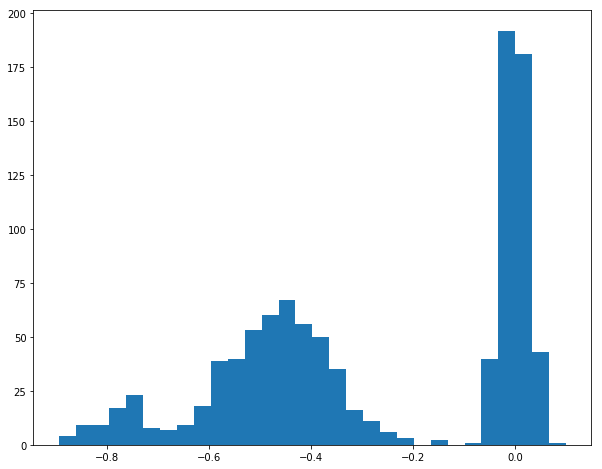

In [383]:
plt.hist(ys[:1000,0] - ys_pred[:,0], bins=30)
plt.show()

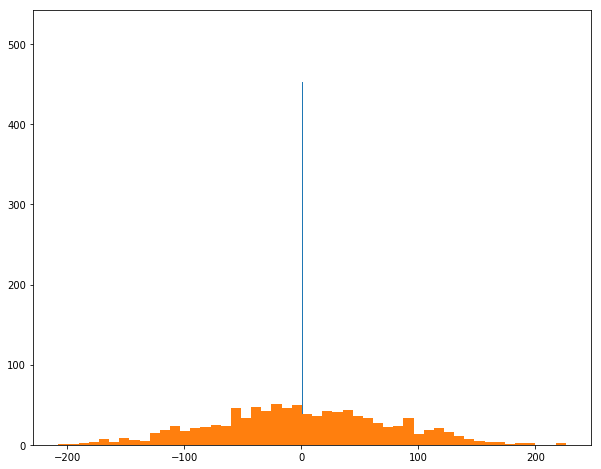

In [387]:
_, bins, _ = plt.hist(ys_pred[:,2], bins=50)
plt.hist(ys[:1000,2], bins=50)
plt.show()